In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.utils as utils
from   tensorflow.keras.preprocessing.image import ImageDataGenerator
from   tensorflow.keras.models import Sequential
from   tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, ZeroPadding2D
from   tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from   tensorflow.keras.utils import plot_model
from   tensorflow.keras.callbacks import ModelCheckpoint
from   pathlib import Path
from   tensorflow.keras import models, layers, optimizers
from   sklearn.utils.class_weight import compute_class_weight
warnings.filterwarnings("ignore")

2025-06-09 04:01:12.675152: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749441672.879773      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749441672.937163      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Descarga de datos y analisis de datos y etiquetas

In [2]:
import kagglehub

# Download latest version
#data_download = kagglehub.dataset_download("fatemehboloori/trash-type-detection")

data_path = '/kaggle/input/trash-type-detection/trash_images'

# Data Classes
print(os.listdir(data_path))

['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


In [3]:
main_folder_path = Path(data_path)

all_folders = [d for d in main_folder_path.glob('**/') if d.is_dir()]

# Count number of files in each class
data = [] 
for folder in all_folders:
    folder_name = folder.name
    file_count = len(list(folder.glob('*.*')))
    if folder_name != data_path: 
        data.append({'Folder Name': folder_name, 'File Count': file_count})

count = pd.DataFrame(data)

count = count.set_index('Folder Name')
count

,File Count
Folder Name,
trash_images,0
metal,410
glass,501
paper,594
trash,137
cardboard,403
plastic,482


In [4]:
print(f'Total {count.sum()}')

Total File Count    2527
dtype: int64


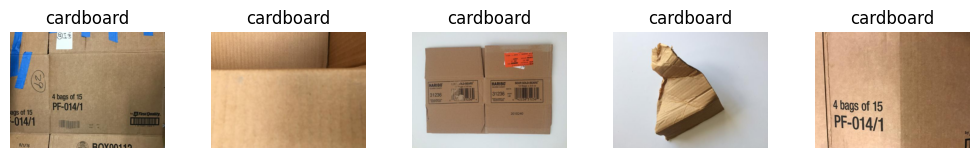

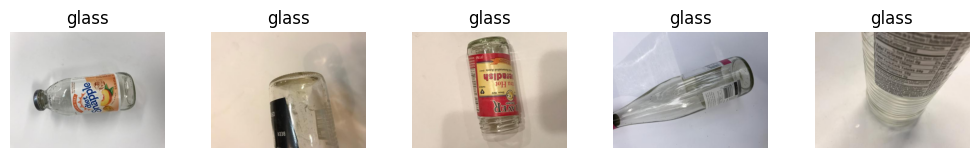

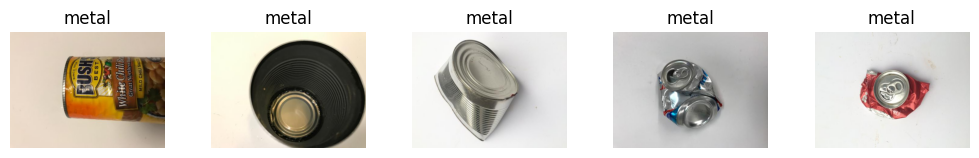

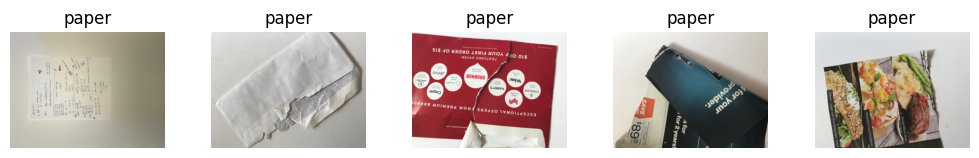

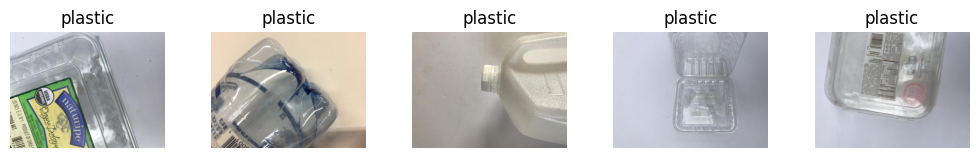

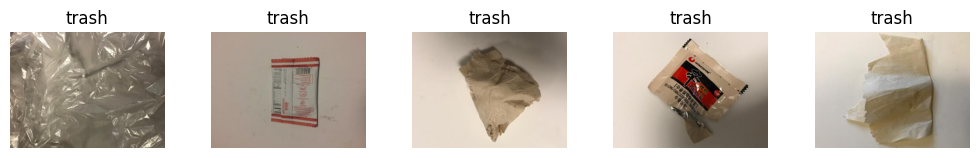

In [5]:
# Show five image of each class
def plot_imgs(item_dir, top=10):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:5]
  
    plt.figure(figsize=(10, 10))
  
    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)
    
        img = plt.imread(img_path)
        plt.tight_layout()         
        plt.imshow(img, cmap='gray') 
        plt.axis('off')
        plt.title(os.path.basename(item_dir)) 


plot_imgs(data_path+'/cardboard')
plot_imgs(data_path+'/glass')
plot_imgs(data_path+'/metal')
plot_imgs(data_path+'/paper')
plot_imgs(data_path+'/plastic')
plot_imgs(data_path+'/trash')

# segmentacion de datos

In [6]:
# Define variable for requirements
batch_size = 30
target_size = (224, 224)
validation_split = 0.15

Aumenta los datos de entrenamiento

In [7]:
# Data Generators
train_img_generator = ImageDataGenerator(rescale=1./255,
                                         validation_split=validation_split,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         zoom_range = 0.5,
                                         width_shift_range = 0.3,
                                         height_shift_range = 0.3,
                                         rotation_range=50,
                                         shear_range = 0.3,
                                         fill_mode='nearest'
                                        )

test_data_img_generator = ImageDataGenerator(rescale=1./255,
                                             validation_split=validation_split
                                            )

Archivos de prueba y datos divididos

Cambiar categorical a Sparse

les da formato al cnjto de datos

In [8]:
# Separate validation Data
test_data = test_data_img_generator.flow_from_directory(data_path,
                                                        subset="validation",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                       )

Found 377 images belonging to 6 classes.


In [9]:
# Separate train Data
train_data = train_img_generator.flow_from_directory(data_path,
                                                        subset="training",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                       )


Found 2150 images belonging to 6 classes.


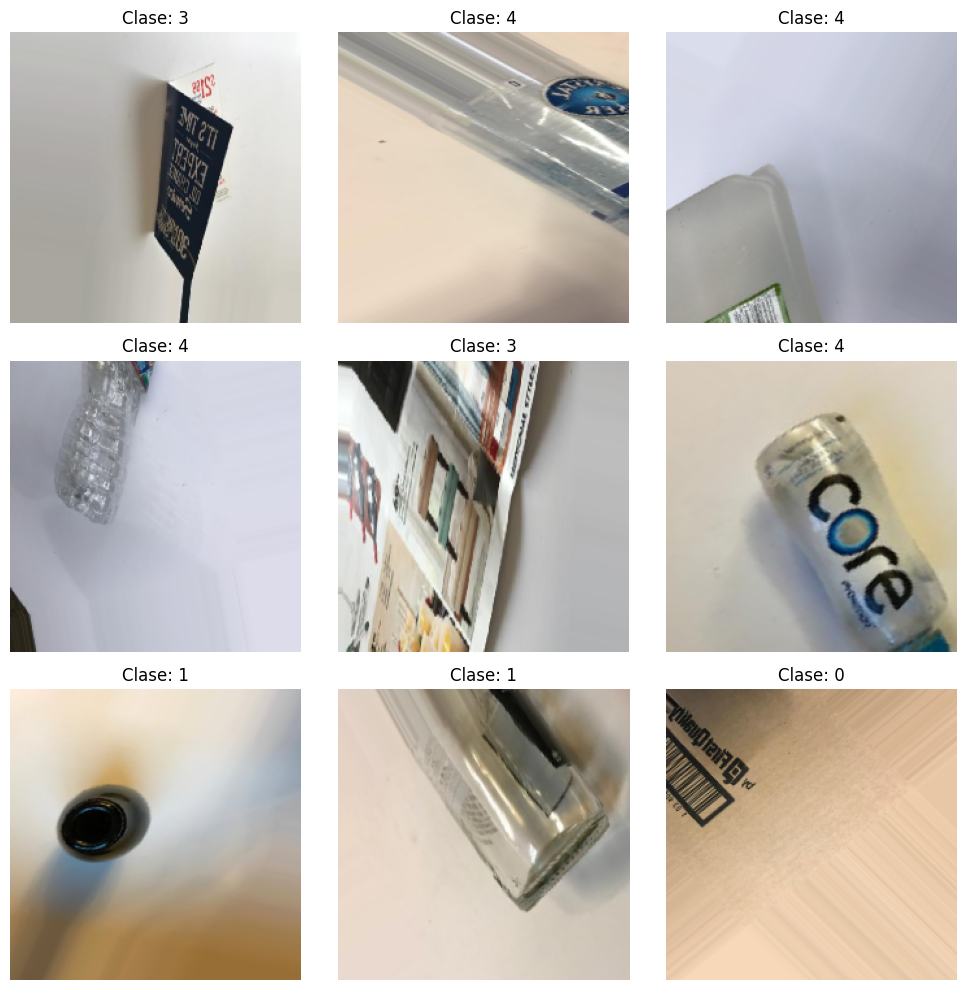

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener un batch de imágenes y etiquetas
images, labels = next(train_data)  # O next(test_data) para validación

# Visualizar las primeras 9 imágenes del batch
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(f"Clase: {np.argmax(labels[i])}")
plt.tight_layout()
plt.show()

# **Arquitectura de la red****

In [11]:
model = Sequential()
model.add(ZeroPadding2D(padding=(1, 1), input_shape=(target_size[0], target_size[1], 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Dropout(0.4))
model.add(MaxPool2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

I0000 00:00:1749441695.670120      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


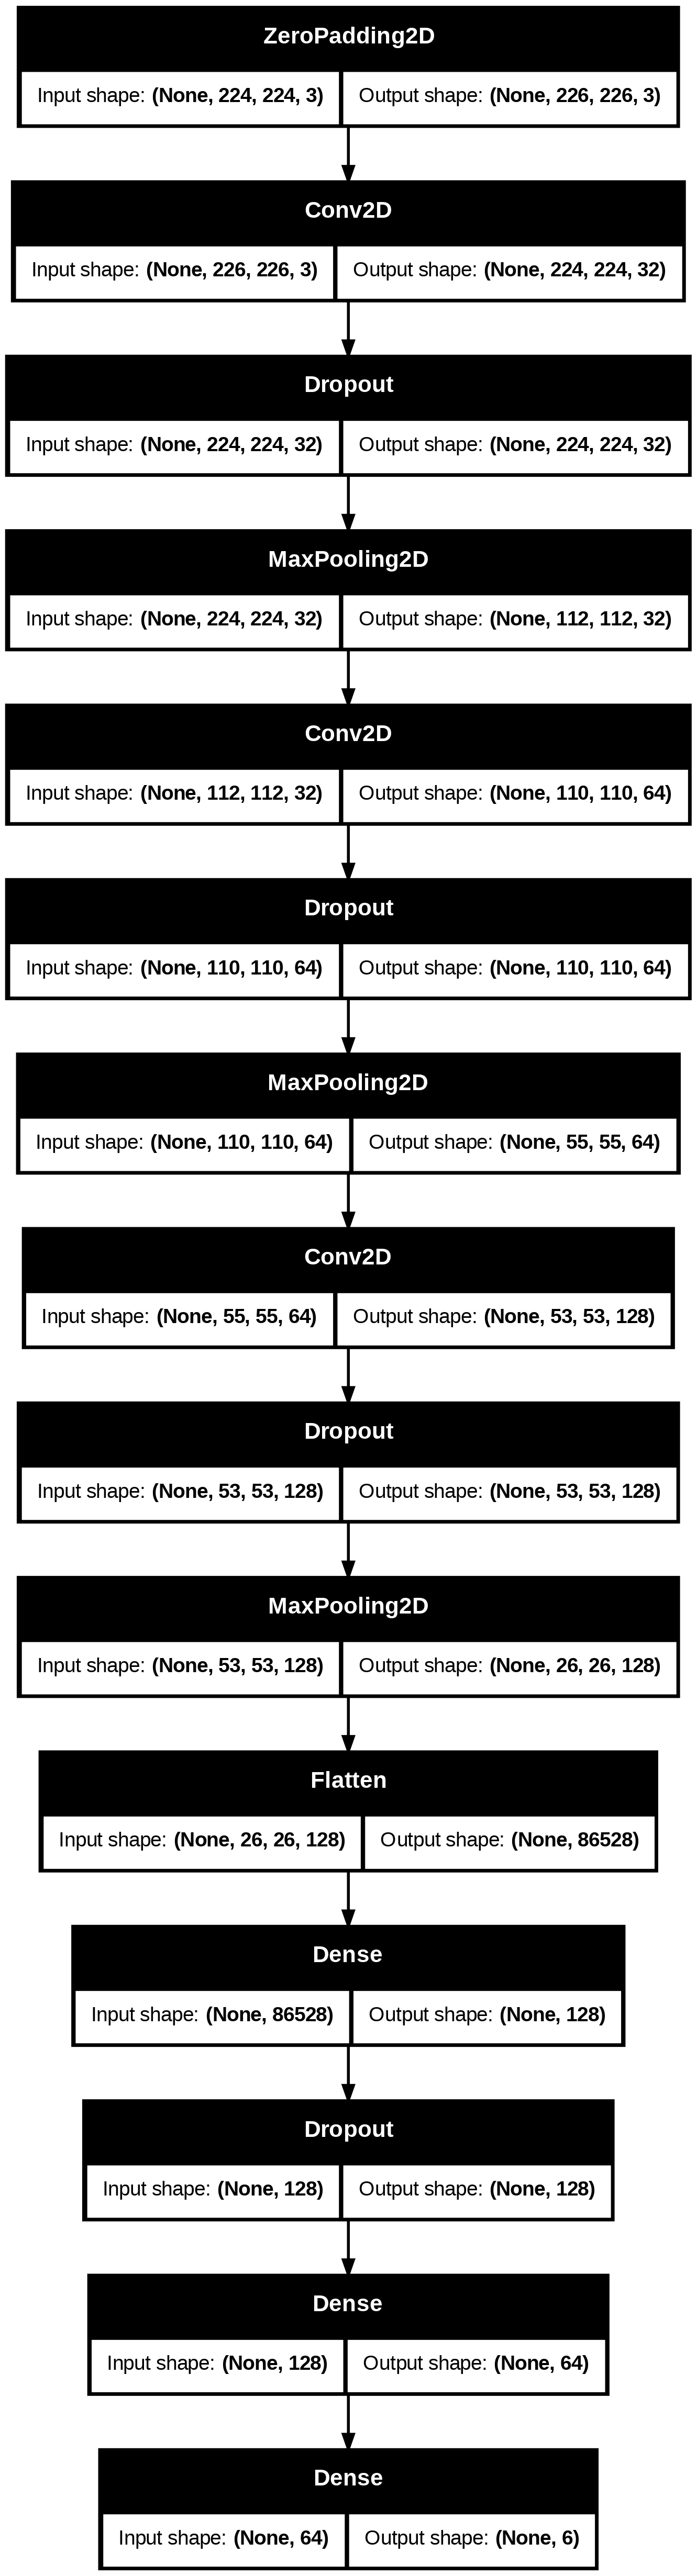

In [12]:
plot_model(model, show_shapes=True, show_layer_names=False)

detiene cuando hay sobreentrenamiendo o cuando la tasa se estanca

In [13]:
ES = EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [14]:
RLROP = ReduceLROnPlateau(
    monitor='val_loss',   # Vigila la pérdida en validación
    patience=5,           # Espera 5 épocas sin mejora antes de reducir el learning rate
    factor=0.1,           # Multiplica el learning rate actual por 0.1 (lo reduce a la décima parte)
    min_lr=0.01           # No baja el learning rate por debajo de 0.01
)

In [15]:
MCH = ModelCheckpoint(
    'trash.h5',           # Nombre del archivo donde se guardará el modelo
    monitor='val_loss',   # Métrica a observar (aquí, la pérdida de validación)
    mode='min',           # Busca el valor mínimo de la métrica
    save_best_only=True   # Solo guarda el modelo si mejora la métrica monitoreada
)

In [16]:
model.compile(
    optimizer='adam',  # 1. Optimizador Adam (rápido y eficiente)
    loss=tf.keras.losses.CategoricalCrossentropy(),  # 2. Función de pérdida para etiquetas one-hot
    metrics=[tf.keras.metrics.CategoricalAccuracy()]  # 3. Métrica: exactitud para clasificación multiclase one-hot
)

Entrenamiento del Modelo

In [17]:
history = model.fit(
    train_data,                        # 1. Datos de entrenamiento (generador o dataset)
    steps_per_epoch=len(train_data),   # 2. Número de pasos por época (aquí, igual al número de lotes en train_data)
    epochs=5,                        # 3. Máximo número de épocas (vueltas sobre todos los datos)
    validation_data=test_data,         # 4. Datos de validación (generador o dataset)
    validation_steps=len(test_data),   # 5. Número de pasos de validación por época
    callbacks=[ES, RLROP, MCH]         # 6. Callbacks: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)

Epoch 1/5


I0000 00:00:1749441701.998163      76 service.cc:148] XLA service 0x7b723800e990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749441701.999214      76 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749441702.377727      76 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/72 ━━━━━━━━━━━━━━━━━━━━ 10:44 9s/step - categorical_accuracy: 0.0333 - loss: 1.9205

I0000 00:00:1749441707.887935      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


72/72 ━━━━━━━━━━━━━━━━━━━━ 45s 510ms/step - categorical_accuracy: 0.2327 - loss: 2.0989 - val_categorical_accuracy: 0.3767 - val_loss: 1.5813 - learning_rate: 0.0010
Epoch 2/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 353ms/step - categorical_accuracy: 0.3745 - loss: 1.5477 - val_categorical_accuracy: 0.2759 - val_loss: 1.6756 - learning_rate: 0.0010
Epoch 3/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 355ms/step - categorical_accuracy: 0.3163 - loss: 1.6099 - val_categorical_accuracy: 0.3634 - val_loss: 1.4752 - learning_rate: 0.0010
Epoch 4/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 345ms/step - categorical_accuracy: 0.4105 - loss: 1.4504 - val_categorical_accuracy: 0.4721 - val_loss: 1.4928 - learning_rate: 0.0010
Epoch 5/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 350ms/step - categorical_accuracy: 0.3742 - loss: 1.4865 - val_categorical_accuracy: 0.3899 - val_loss: 1.4685 - learning_rate: 0.0010


PASO 8 EVALUCAION DEL MODELO

In [18]:
# Obtiene y muestra la mejor accuracy de validación alcanzada durante el entrenamiento
best_score = max(history.history['val_categorical_accuracy'])
print(f"Best Validation score is: {best_score}")

Best Validation score is: 0.4721485376358032


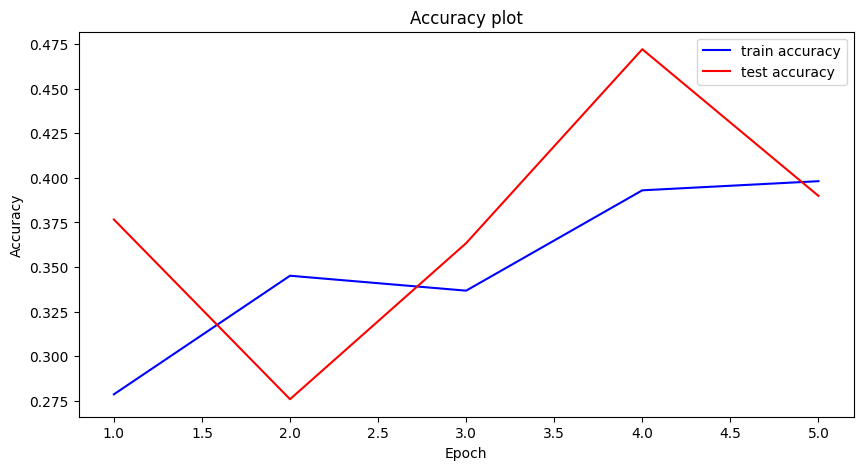

In [19]:
# Obtiene la accuracy del entrenamiento
accuracy = history.history['categorical_accuracy']

# Obtiene la accuracy en validación (test)
val_accuracy = history.history['val_categorical_accuracy']

# Define el rango de épocas
epochs = range(1, len(accuracy) + 1)

# Grafica la accuracy por época para entrenamiento y validación
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, 'b', label='train accuracy')
plt.plot(epochs, val_accuracy, 'r', label='test accuracy')
plt.title('Accuracy plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

USing the model

In [20]:
classes = train_data.class_indices
classes

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

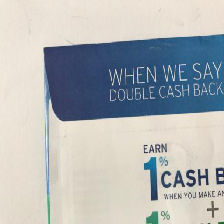

In [21]:
img = utils.load_img(
    '/kaggle/input/trash-type-detection/trash_images/paper/paper_001.jpg',  # Ruta de la imagen a cargar
                 # No cargar en escala de grises (carga en color)
    color_mode='rgb',                    # Cargar la imagen en modo RGB
    target_size=(224, 224),              # Redimensionar la imagen a 180x180 píxeles
    interpolation='nearest',             # Método de interpolación para el reescalado (el más rápido)
    keep_aspect_ratio=False              # No mantiene la proporción original (puede deformar la imagen)
)

img  # Muestra un objeto tipo PIL.Image.Image

In [22]:
# Convierte la imagen PIL a array NumPy
img = utils.img_to_array(img)

# Normaliza los valores de píxeles a rango [0, 1]
img = img / 255.0

# Predice la clase de la imagen (agrega dimensión batch)
result = model.predict(tf.expand_dims(img, axis=0))

# Obtiene el diccionario {nombre_clase: índice}
classes = train_data.class_indices

# Imprime el nombre de la clase con mayor probabilidad
for key, value in classes.items():
    if value == np.argmax(result):
        print(key)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
cardboard


# Con CNN RESTNET

In [23]:
from tensorflow.keras.applications import ResNet50

# Load pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
train_dir = '/kaggle/input/trash-type-detection/trash_images/'
test_dir = '/kaggle/input/trash-type-detection/trash_images/'

# ImageDataGenerator for loading images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess data
batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
Found 2527 images belonging to 6 classes.


In [25]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model

# Parámetros
input_shape = (224, 224, 3)
num_classes = 6  # Cambia esto al número de clases que tienes

# Cargar modelo base preentrenado
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
base_model.trainable = False  # Opcional: congela pesos del modelo base

# Capas adicionales personalizadas
x = base_model.output
# Opcional: capas convolucionales extra después del base_model
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.3)(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.3)(x)

# Global Average Pooling para reducir dimensionalidad
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

# Modelo final
model2 = Model(inputs=base_model.input, outputs=output)

# Compilar el modelo
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Resumen del modelo
model2.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,662,118 (10.16 MB)

 Trainable params: 404,134 (1.54 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [26]:
# Train the model
history = model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=30  # Adjust epochs as needed
   #callbacks=[ES, RLROP, MCH]  
    
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 560ms/step - accuracy: 0.2594 - loss: 1.8323 - val_accuracy: 0.4688 - val_loss: 1.3337
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.3750 - loss: 1.4993 - val_accuracy: 0.4958 - val_loss: 1.3086
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 438ms/step - accuracy: 0.4642 - loss: 1.2645 - val_accuracy: 0.5021 - val_loss: 1.0613
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.4062 - loss: 1.4335 - val_accuracy: 0.4833 - val_loss: 1.0943
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 440ms/step - accuracy: 0.5273 - loss: 1.1065 - val_accuracy: 0.6500 - val_loss: 0.9323
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.6250 - loss: 1.0180 - val_accuracy: 0.6771 - val_loss: 0.9040
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 437ms/step - accuracy: 0.6206 - loss: 0.9479 - val_accuracy: 0.6854 - val_loss: 0.9392
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.6875 - loss: 0.9407 - val_accuracy: 0.

In [27]:
# Evaluate the model on test data
test_loss, test_accuracy = model2.evaluate(test_generator, verbose=1)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - accuracy: 0.8492 - loss: 0.4609
Test Loss: 0.4486
Test Accuracy: 0.8560


79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step


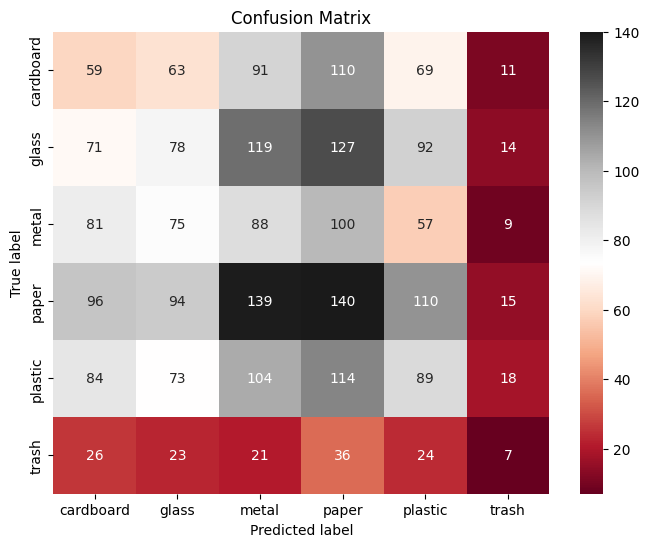

In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get raw predictions from the model
y_pred_prob = model2.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels

# Get true labels from the generator
y_true = test_generator.classes

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class names based on your generator class indices
class_names = list(test_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="RdGy", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
